Michael Uftring   
Indiana University   
Network Science, Spring 2018   
Week#13 Assignment - The Threshold model

# The Threshold model
We will build a basic threshold model and then use it to explore the dynamical space of the model on a real network and then to compare spreading processes between real graphs and randomized versions of those graphs. In the reading we learned that simple contagions and complex contagions differ in the way they spread which can have a huge impact on the resulting dynamics of the system. This is particularly important when considering social systems.

In Granovetter's paper we saw how adjusting the standard deviation of thresholds in a crowd induced a phase-transition where the crowd went from exhibiting no/limited rioting behavior to a full blown riot. However, the Granovetter model assumes perfect mixing in the population. Granovetter was aware of this and alluded to extensions of the model that could include friendship information and social ties. Lets try implementing a network version of the model that takes into account binary social ties between individuals.

In [1]:
import networkx as nx
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# We will take three arguments for our function. The first
# being a networkx graph, the second being the mean of the
# threshold distribution, the third being the standard
# deviation of the threshold distribution
def threshold_model(graph, mean, std):
     
    # First lets create our distribution of thresholds.
    # Numpy has many different kinds of distributions, and
    # you can easily replace 'normal' with a 'gamma' or 'beta'
    # or 'uniform' or any other of your choosing, though the
    # parameters will change.
    threshold_distribution = np.random.normal(mean, std, size=len(graph))
    # I create a dictionary with keys=nodes and values=thresholds
    # that will store the threshold value for each node for future reference
    node_thresholds = { node: threshold_distribution[i] for i, node in enumerate(graph.nodes()) }
    
    # Now lets select a seed. We will pick a random node from the graph
    # along with its immediate neighbors as the set of initially active nodes
    # (alternatively we could just pick one node at random as the seed)
    seed_node = np.random.choice(graph.nodes())
    seed_neighbors = list(graph[seed_node].keys())
    seed_neighbors.append(seed_node)
    seeds = set(seed_neighbors)
    
    # In our model we will only allow for activation, not deactivation, so we
    # can cut down on processing time a bit by only looping over inactive nodes
    # when updating. The inactive set is just the rest of the nodes less the seeds:
    inactive_nodes = set(graph.nodes()) - seeds
    
    # We want as our output the fraction of nodes that are active in the graph 
    # when the process has reached equilibrium. We can check if the process
    # is at equilibrium if between two time steps no new nodes become active.
    # So we will use the 'previous_set' variable to keep track of this
    # and iterate through a 'while loop' that exits when equilibrium is 
    # reached (since we can only activate nodes we are guaranteed to reach
    # some equilibrium, even if it takes a long time)
    previous_set = set([])
    while (previous_set != inactive_nodes):
        previous_set = set(inactive_nodes)
        
        # We will be using an asynchronous update scheme that randomly
        # orders the inactive nodes and then updates them in that sequence.
        # First turn the inactive nodes into a list and shuffle it using
        # the shuffle function from python, then we iterate over that list.
        update_sequence = list(inactive_nodes)
        random.shuffle(update_sequence)
        for node in update_sequence:
            # We add up the number of active neighbors that the node has.
            # You can easily extend this to work with weighted graphs by
            # substituting 1 with edge weights. 
            num_active_neighbors = np.sum([ 0 if neighbor in inactive_nodes else 1 
                                           for neighbor in graph.neighbors(node)])
            
            # Now we check if the activity from our neighbors pushes us over
            # the threshold...
            if (num_active_neighbors >= node_thresholds[node]):
                # if it does, then we just remove that node from the inactive list
                inactive_nodes.remove(node)
                
    # Return the fraction of active nodes at equilibrium
    return 1 - len(inactive_nodes) / len(graph)

Our threshold model is complete. It is only one variant of many. For instance, with a few small modifications we could change it to use the fraction of neighbors instead of an absolute threshold.

Lets go ahead and load in a real graph and then apply this model to it and randomized versions of the [Americal college football graph](http://www-personal.umich.edu/~mejn/netdata/) which I choose because it has a distict community structure based on the geographic location of the teams:

In [3]:
def probabilityForDegree(N, k):
    return k/(N-1)

**Note:** converted Football network file from GML -> Pajek (NET)

In [4]:
football = nx.read_pajek('football.net')
football = nx.Graph(football)
print(nx.info(football))

Name: 
Type: Graph
Number of nodes: 115
Number of edges: 613
Average degree:  10.6609


We can do two different randomizations: one in which we hold only the number of nodes and edges roughly constant, and one where we hold the degree sequence constant. We can then compare the results.

In [5]:
# Lets pick a range of standard deviations and means to loop over
# You will have to adjust this range and play with it so that it fits
# your graph. I exaplored the dynamical space of the system
# before in order to figure out what range of values to pick,
# that part will be left to you in the homework.
stds = np.linspace(0.01, 8.0, 30)
means = np.linspace(1.0, 6.0, 30)
# And of course we need the degree sequence for the graph
deg_seq = list(dict(nx.degree(football)).values())
# And for the random graph
N = len(football.nodes())
k = np.mean(list(football.degree().values()))
p = probabilityForDegree(N, k)

In [6]:
# some constant values
ITERATIONS = 300
MEAN = 4.0
STDDEV = 0.01

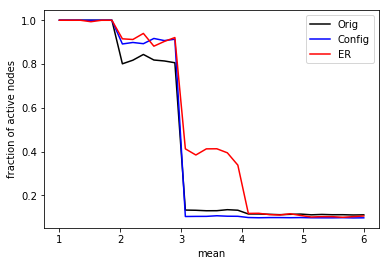

In [72]:
# I will make three plots. The first will be the original network,
# the second will be the configuration model, and the last will be
# an Erdos-Renyi graph that has the same average degree.

# The code is pretty compressed, but it uses an outside list
# comprehension to iterate through each mean in the means list to
# build a list of equilibrium points.
# The inside list comprehension is just used to get the average, since
# this is a random process it will give different values for each
# iteration (both in the simulation and the graph generation).
plt.plot(means, [ np.mean([threshold_model(football, mean, STDDEV) 
                           for i in range(ITERATIONS) ]) 
                 for mean in means], color='black', label='Orig')
plt.plot(means, [ np.mean([threshold_model(nx.configuration_model(deg_seq), mean, STDDEV) 
                           for i in range(ITERATIONS) ])
                 for mean in means], color='blue', label='Config')
plt.plot(means, [ np.mean([threshold_model(nx.erdos_renyi_graph(N, p), mean, STDDEV) 
                           for i in range(ITERATIONS) ]) 
                 for mean in means], color='red', label='ER')
plt.legend(loc='upper right')

For these runs I kept the standard deviation low so that the threshold is effectively the same for everyone. This results in a rather sharp critical point where the system spreads very easily and then doesn't spread at all. However, you might notice that there are several plateaus as well. What do you think causes them? Why do you think the ER graph is the only one with the last plateau?

Lets hold the means constant and vary the standard deviation and set the `mean=4.0`:

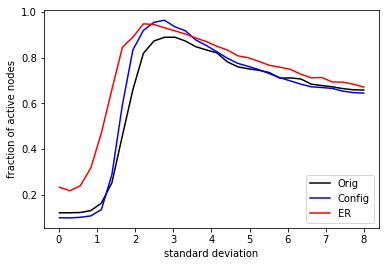

In [73]:
plt.plot(stds, [ np.mean([threshold_model(football, MEAN, std) 
                           for i in range(ITERATIONS) ]) 
                 for std in stds], color='black', label='Orig')
plt.plot(stds, [ np.mean([threshold_model(nx.configuration_model(deg_seq), MEAN, std) 
                           for i in range(ITERATIONS) ])
                 for std in stds], color='blue', label='Config')
plt.plot(stds, [ np.mean([threshold_model(nx.erdos_renyi_graph(N, p), MEAN, std) 
                           for i in range(ITERATIONS) ]) 
                 for std in stds], color='red', label='ER')
plt.legend(loc="lower right")

Here we can see a similar transition as the one in Granovetter's paper, which is fascinating! It means that at least approximately, some of the results from the well-mixed case appear in our network version of the model. While spreading results in the same outcomes for larger stardard deviations, below 2 we can see that the original graph and configuration model are notably worse than the ER version of the graph, suggesting that some aspect of the degree distribution in the football network is deterimental to spreading of complex contagions. Additionally, we can see that there is a cross-over point around 1 below which the real graph is better for spreading than the configuration model, and above which it is worse, suggesting that there are finer details in the real graph beyond degree distribution that effect the spreading process. How significant these differences are would require a more thorough analysis and perhaps some hypothesis testing.

# Assignment
1. Pick a real-world graph and load it into networkx.
2. Explore the parameters of the model using just the real-world graph. Find a range of means and standard deviations that captures the full range of dynamics the model has on the network. In general it is best to start with a wide range of values and then hone in on regions of interest. Though you only have to vary one parameter at a time, matplotlib also has a [contour](http://matplotlib.org/api/pyplot_api.html?highlight=contour#matplotlib.pyplot.contour) function that will let you vary both simultaneously while plotting the equilibrium points along a z-axis. You can do this if you are feeling adventurous (though I recommend googling a tutorial first since it works differently than a normal plot function). If making a contour is too difficult, but you want to see how one parameters varies as another does, you can always make overlapping plots, similar to what I have made above but using different parameter values for each plot.
3. Once you have a good grasp on where the action is, compare your real graph with a configuration model and a comparable ER graph like I do above. Use the intuition you built up in step 2 for picking values of the mean to hold constant at, as different means can place you in different dynamical regimes resulting in very different behavior.
4. Provide a written summary of what you found in steps 2 and 3 in a markdown section in your notebook. Make note of any interesting spreading behavior your graph has and try to explain it if you can. Describe any similarities or differences between the real graph and the random graphs and consider why those similarities or differences exist.
5. Submit your completed notebook to Canvas when you are complete.

## Dolphins

In [51]:
dolphins = nx.read_pajek("dolphins.net")
dolphins = nx.Graph(dolphins)
print(nx.info(dolphins))

Name: 
Type: Graph
Number of nodes: 62
Number of edges: 159
Average degree:   5.1290


In [52]:
graph = dolphins
stds = np.linspace(0.001, 8.0, 64)
means = np.linspace(0.0, 6.0, 64)
deg_seq = list(dict(nx.degree(graph)).values())
N = len(graph.nodes())
k = np.mean(list(graph.degree().values()))
p = probabilityForDegree(N, k)

In [53]:
ITERATIONS = 300
MEAN = 2.0
STDDEV = 0.1

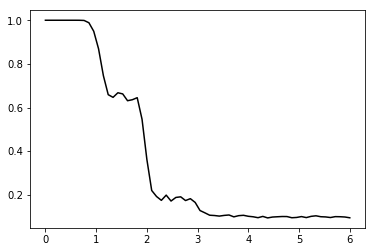

In [54]:
plt.plot(means, [ np.mean([threshold_model(graph, mean, STDDEV) 
                           for i in range(ITERATIONS) ]) 
                 for mean in means], color='black', label='Orig')

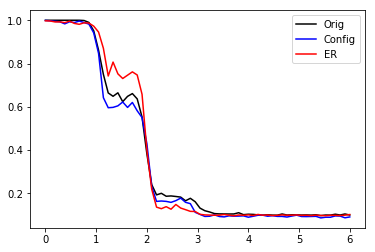

In [55]:
plt.plot(means, [ np.mean([threshold_model(graph, mean, STDDEV) 
                           for i in range(ITERATIONS) ]) 
                 for mean in means], color='black', label='Orig')
plt.plot(means, [ np.mean([threshold_model(nx.configuration_model(deg_seq), mean, STDDEV) 
                           for i in range(ITERATIONS) ])
                 for mean in means], color='blue', label='Config')
plt.plot(means, [ np.mean([threshold_model(nx.erdos_renyi_graph(N, p), mean, STDDEV) 
                           for i in range(ITERATIONS) ]) 
                 for mean in means], color='red', label='ER')
plt.legend(loc='upper right')

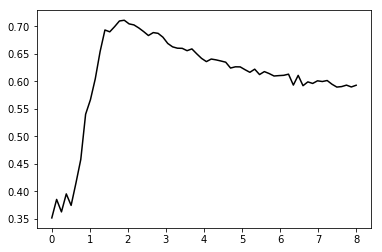

In [56]:
plt.plot(stds, [ np.mean([threshold_model(graph, MEAN, std) 
                           for i in range(ITERATIONS) ]) 
                 for std in stds], color='black', label='Orig')

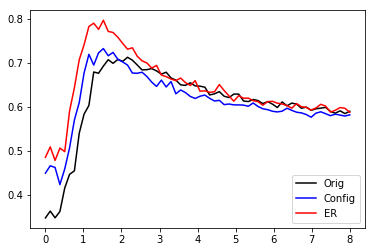

In [57]:
plt.plot(stds, [ np.mean([threshold_model(graph, MEAN, std) 
                           for i in range(ITERATIONS) ]) 
                 for std in stds], color='black', label='Orig')
plt.plot(stds, [ np.mean([threshold_model(nx.configuration_model(deg_seq), MEAN, std) 
                           for i in range(ITERATIONS) ])
                 for std in stds], color='blue', label='Config')
plt.plot(stds, [ np.mean([threshold_model(nx.erdos_renyi_graph(N, p), MEAN, std) 
                           for i in range(ITERATIONS) ]) 
                 for std in stds], color='red', label='ER')
plt.legend(loc="lower right")